## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
import re
import pickle
import joblib
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold

In [20]:
df_users = pd.read_csv("df_user.csv")
df_keys = pd.read_csv("df_keys.csv")

In [21]:
hold_by_user =  df_keys[df_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean'])
latency_by_user = df_keys[np.in1d(df_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['LatencyTime'].agg(['mean'])

In [22]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]

In [23]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]

In [24]:
# hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']

In [25]:
# latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
# latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']

In [26]:
combined = pd.concat([hold_by_user_flat, latency_by_user_flat], axis=1)

In [27]:
full_set = pd.merge(combined.reset_index(), df_users[['ID', 'Parkinsons']], on='ID')


In [28]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)

In [29]:
X = full_set.drop(columns=['Parkinsons', 'ID'], axis=1)
y = full_set['Parkinsons']

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [31]:
lda_model = LDA()
lda_model.fit(X, y)

LinearDiscriminantAnalysis()

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
from sklearn.model_selection import cross_validate
rf.fit(X, y)
cv = cross_val_score(rf, X, y, cv=5)
print(cv.mean())

0.48161764705882354


In [ ]:
#save model 
joblib.

In [33]:
import shap

In [34]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X)

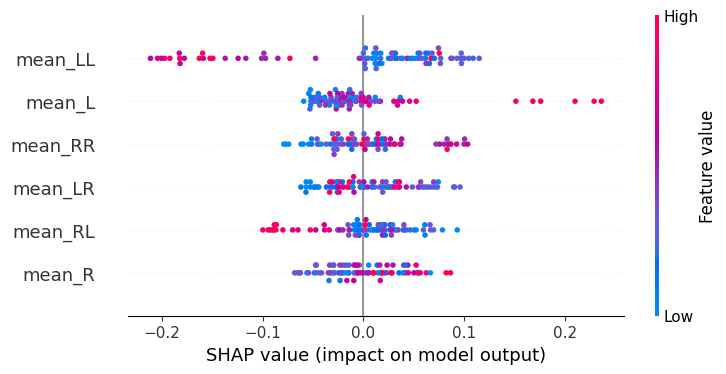

In [35]:
shap.initjs()
shap.plots.beeswarm(shap_values[:,:,1], max_display=27)

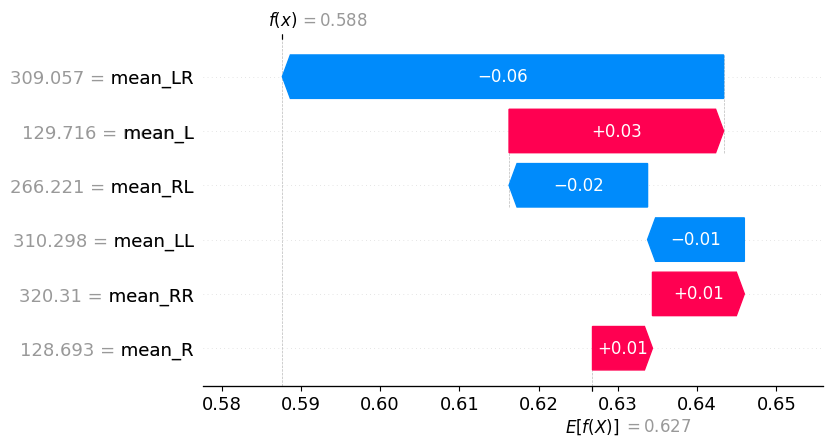

In [38]:
shap.plots.waterfall(shap_values[9,:,0], max_display=27)

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold

In [ ]:
X_train,

In [2]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # so that the log loss is recorded during training
    # Add other parameters as needed
}

# Convert X_train and y_train
dtrain = xgb.DMatrix(X_train, label=y_train)

# Perform cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='logloss', early_stopping_rounds=10)

# Extract log loss values for training and validation sets
train_log_loss = cv_results['train-logloss-mean']
test_log_loss = cv_results['test-logloss-mean']

# Plot the learning curve for log loss
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss, label='Train Log Loss')
plt.plot(test_log_loss, label='Test Log Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Log Loss Learning Curve')
plt.legend()
plt.show()

# Get the best number of boosting rounds from cross-validation
best_num_boost_rounds = len(cv_results)

# Split the training data to create a validation set
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create DMatrices for the training and validation data
dtrain_part = xgb.DMatrix(X_train_part, label=y_train_part)
dval = xgb.DMatrix(X_val, label=y_val)

# Specify validation sets to watch performance
evals = [(dtrain_part, 'train'), (dval, 'eval')]

# Train the final model using the training part and include early stopping
final_model = xgb.train(params, dtrain_part, num_boost_round=best_num_boost_rounds, evals=evals, early_stopping_rounds=10, verbose_eval=False)

# Make predictions on the validation set
y_val_pred_proba = final_model.predict(dval)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Calculate metrics on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Plot the learning curve for log loss, accuracy, F1 score, precision, and recall
metrics = ['logloss', 'accuracy', 'f1', 'precision', 'recall']
results = {
    'logloss': {
        'train': train_log_loss,
        'test': test_log_loss
    },
    'accuracy': {
        'train': [],
        'test': []
    },
    'f1': {
        'train': [],
        'test': []
    },
    'precision': {
        'train': [],
        'test': []
    },
    'recall': {
        'train': [],
        'test': []
    }
}

# Get metrics for each round during training
for i in range(1, best_num_boost_rounds + 1):
    temp_model = xgb.train(params, dtrain_part, num_boost_round=i)
    y_train_pred_proba_temp = temp_model.predict(dtrain_part)
    y_train_pred_temp = (y_train_pred_proba_temp > 0.5).astype(int)
    y_val_pred_proba_temp = temp_model.predict(dval)
    y_val_pred_temp = (y_val_pred_proba_temp > 0.5).astype(int)

    results['accuracy']['train'].append(accuracy_score(y_train_part, y_train_pred_temp))
    results['accuracy']['test'].append(accuracy_score(y_val, y_val_pred_temp))
    results['f1']['train'].append(f1_score(y_train_part, y_train_pred_temp))
    results['f1']['test'].append(f1_score(y_val, y_val_pred_temp))
    results['precision']['train'].append(precision_score(y_train_part, y_train_pred_temp))
    results['precision']['test'].append(precision_score(y_val, y_val_pred_temp))
    results['recall']['train'].append(recall_score(y_train_part, y_train_pred_temp))
    results['recall']['test'].append(recall_score(y_val, y_val_pred_temp))

# Plot the learning curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Accuracy
axs[0, 0].plot(results['accuracy']['train'], label='Train Accuracy')
axs[0, 0].plot(results['accuracy']['test'], label='Test Accuracy')
axs[0, 0].set_xlabel('Number of Boosting Rounds')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Accuracy Learning Curve')
axs[0, 0].legend()

# F1 Score
axs[0, 1].plot(results['f1']['train'], label='Train F1 Score')
axs[0, 1].plot(results['f1']['test'], label='Test F1 Score')
axs[0, 1].set_xlabel('Number of Boosting Rounds')
axs[0, 1].set_ylabel('F1 Score')
axs[0, 1].set_title('F1 Score Learning Curve')
axs[0, 1].legend()

# Precision
axs[1, 0].plot(results['precision']['train'], label='Train Precision')
axs[1, 0].plot(results['precision']['test'], label='Test Precision')
axs[1, 0].set_xlabel('Number of Boosting Rounds')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].set_title('Precision Learning Curve')
axs[1, 0].legend()

# Recall
axs[1, 1].plot(results['recall']['train'], label='Train Recall')
axs[1, 1].plot(results['recall']['test'], label='Test Recall')
axs[1, 1].set_xlabel('Number of Boosting Rounds')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].set_title('Recall Learning Curve')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Assuming X_test is your test data
dtest = xgb.DMatrix(X_test)

# Make predictions on the test set
test_predictions = final_model.predict(dtest)

NameError: name 'X_train' is not defined